# README

Implement CIFER-10 image classification based on simple CNN (Acc=80%), vision transformer (Acc=98%), and convolution mixer (Acc=96%).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
import os
import argparse
import csv
import time
from models import *
from models.vit import ViT
from utils import progress_bar
from models.convmixer import ConvMixer
from randomaug import RandAugment

In [4]:
import numpy as np 
import pandas as pd

In [5]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(len(train_data))
print(len(test_data))

50000
10000


In [8]:
num_workers = 0
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [9]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
dataiter = iter(train_loader)

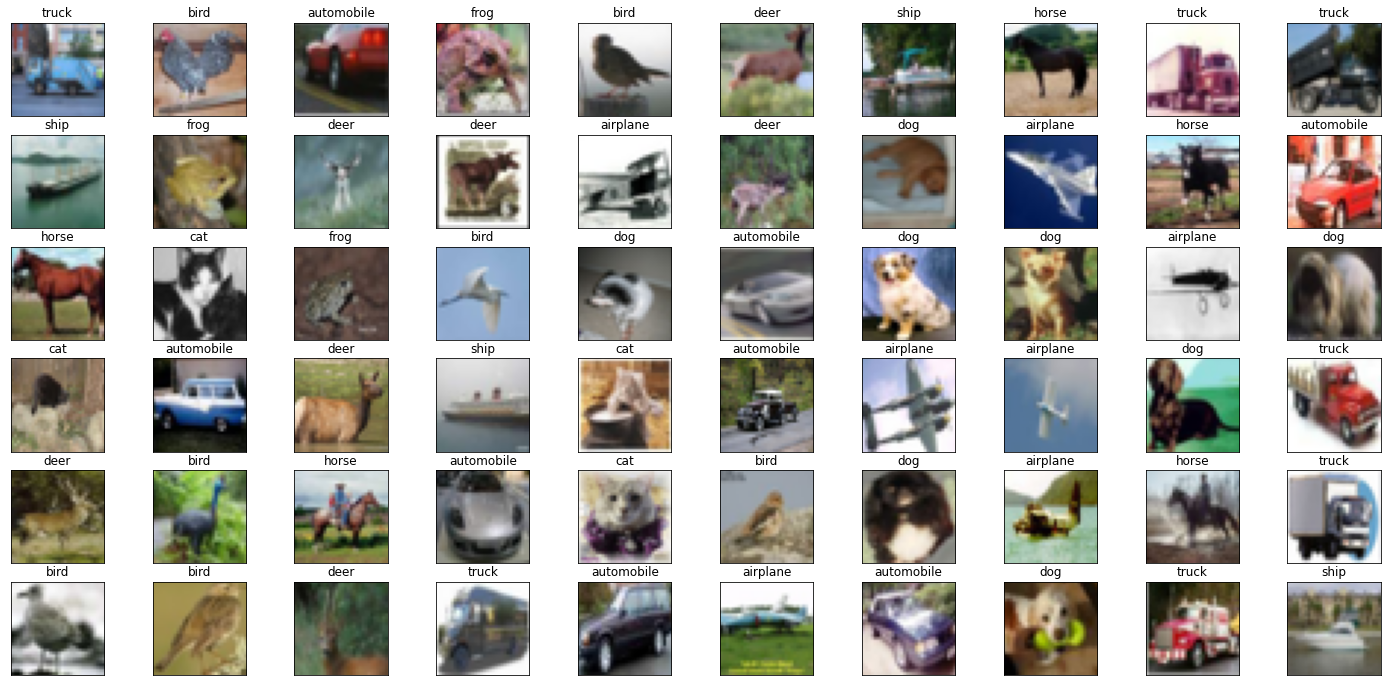

In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(25, 12))
for i in np.arange(60):
    ax = fig.add_subplot(6, 10, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

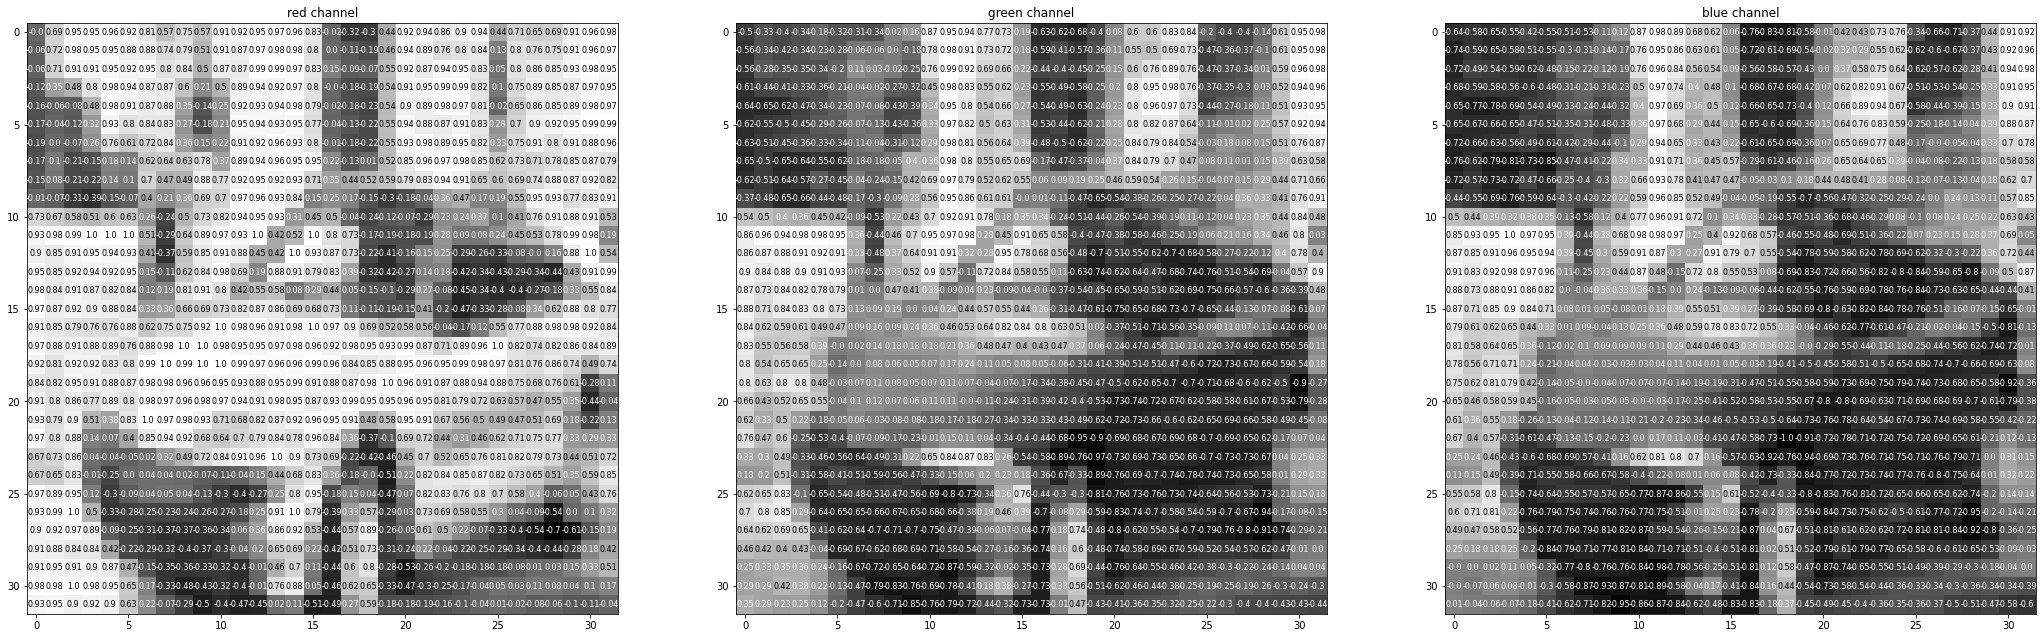

In [12]:
rgb_img = np.squeeze(images[19])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                horizontalalignment='center',
                verticalalignment='center', size=8,
                color='white' if img[x][y]<thresh else 'black')

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [15]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [16]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
train_losslist = []
valid_losslist = []
train_acclist = []
valid_acclist = []

for epoch in range(1, 250+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0

    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        acc = accuracy(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        train_acc += acc.item()*data.size(0)

    model.eval()
    for data, target in test_loader:
        output = model(data)
        acc = accuracy(output, target)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        valid_acc += acc.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    train_acc = train_acc/len(train_loader.dataset)
    valid_acc = valid_acc/len(test_loader.dataset)
    train_losslist.append(train_loss)
    valid_losslist.append(valid_loss)
    train_acclist.append(train_acc)
    valid_acclist.append(valid_acc)
        
    print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t train_acc ->", train_acc, 
          "\n==========\t valid_loss ->", valid_loss, "\t\t\t valid_acc ->", valid_acc)
    
torch.save(model.state_dict(), 'cifar_net.pt')

Epoch -> 1 	 train_loss -> 2.304478365402222 			 train_acc -> 0.10201999999761581 
==========	 valid_loss -> 2.302511714553833 			 valid_acc -> 0.1
Epoch -> 2 	 train_loss -> 2.3016010177612305 			 train_acc -> 0.10363999999523163 
==========	 valid_loss -> 2.2988572578430175 			 valid_acc -> 0.1195
Epoch -> 3 	 train_loss -> 2.29751439491272 			 train_acc -> 0.10974 
==========	 valid_loss -> 2.2911192531585693 			 valid_acc -> 0.1383
Epoch -> 4 	 train_loss -> 2.2871400631713867 			 train_acc -> 0.12806000000953674 
==========	 valid_loss -> 2.2692231468200683 			 valid_acc -> 0.18
Epoch -> 5 	 train_loss -> 2.2576941761779783 			 train_acc -> 0.16226000000953675 
==========	 valid_loss -> 2.2104457096099854 			 valid_acc -> 0.2219
Epoch -> 6 	 train_loss -> 2.202081160507202 			 train_acc -> 0.19176000000953675 
==========	 valid_loss -> 2.122930697250366 			 valid_acc -> 0.2539
Epoch -> 7 	 train_loss -> 2.1400638542938233 			 train_acc -> 0.20902000000953674 
==========	 valid_los

Epoch -> 55 	 train_loss -> 1.1811989715194702 			 train_acc -> 0.57774 
==========	 valid_loss -> 1.0844764010429382 			 valid_acc -> 0.6064
Epoch -> 56 	 train_loss -> 1.1672834812927246 			 train_acc -> 0.583300000038147 
==========	 valid_loss -> 1.0352264236450195 			 valid_acc -> 0.634
Epoch -> 57 	 train_loss -> 1.1655511663818359 			 train_acc -> 0.5857599999809265 
==========	 valid_loss -> 1.036010394859314 			 valid_acc -> 0.6345
Epoch -> 58 	 train_loss -> 1.1558403452301025 			 train_acc -> 0.5883600000381469 
==========	 valid_loss -> 1.050981486225128 			 valid_acc -> 0.6256
Epoch -> 59 	 train_loss -> 1.1463504083633422 			 train_acc -> 0.592319999961853 
==========	 valid_loss -> 1.0541496695518493 			 valid_acc -> 0.6203
Epoch -> 60 	 train_loss -> 1.1402374904251098 			 train_acc -> 0.5941999999809265 
==========	 valid_loss -> 1.0101750010490418 			 valid_acc -> 0.6417
Epoch -> 61 	 train_loss -> 1.1284020174789429 			 train_acc -> 0.600420000038147 
==========	 val

In [ ]:
def plot_accuracies(train_acclist, valid_acclist):
    plt.plot(train_acclist, '-rx')
    plt.plot(valid_acclist, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(train_losslist, valid_losslist):
    plt.plot(train_losslist, '-bx')
    plt.plot(valid_losslist, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [ ]:
plot_accuracies(train_acclist, valid_acclist)

In [ ]:
plot_losses(train_losslist, valid_losslist)

In [ ]:
print("Final Accuracy ->", valid_acclist[-1])

In [ ]:
class CNN(nn.Module):
   

    def __init__(self):
        
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)

        return x

In [ ]:
model = CNN()
print(model)

In [ ]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
train_losslist = []
valid_losslist = []
train_acclist = []
valid_acclist = []

for epoch in range(1, 250+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0

    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        acc = accuracy(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        train_acc += acc.item()*data.size(0)

    model.eval()
    for data, target in test_loader:
        output = model(data)
        acc = accuracy(output, target)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        valid_acc += acc.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    train_acc = train_acc/len(train_loader.dataset)
    valid_acc = valid_acc/len(test_loader.dataset)
    train_losslist.append(train_loss)
    valid_losslist.append(valid_loss)
    train_acclist.append(train_acc)
    valid_acclist.append(valid_acc)
        
    print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t train_acc ->", train_acc, 
          "\n==========\t valid_loss ->", valid_loss, "\t\t\t valid_acc ->", valid_acc)
    
torch.save(model.state_dict(), 'cifar_cnn.pt')

In [ ]:
plot_accuracies(train_acclist, valid_acclist)

In [ ]:
plot_losses(train_losslist, valid_losslist)

In [ ]:
print("Final Accuracy ->", valid_acclist[-1])